In [1]:
# necessary imports

import numpy as np
from numpy import linalg as LA

import scipy.sparse as sparse
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib
import pickle
import sys

sys.path.append('utils')

import itertools
import functools
import progressbar
import operator
import time

from importlib import reload
from functions_regression import *
from functions_PDE_solver import *

folder = 'store'

In [2]:
!type python

python is /opt/packages/anaconda3/bin/python


In [3]:
!ls "$folder"

data_N_100_V0_-0.30_U_0.00_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.01_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.02_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.03_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.04_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.05_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.06_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.07_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.08_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.09_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.10_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.11_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.12_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.13_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.14_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.15_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.16_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.17_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.18_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.19_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.20_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.21_J_0.50_

In [4]:
# to load saved data for analysis (check ls above)
N_site = 120 # number of sites
V0 = -0.3 # depth starting potential (deeper for larger U to still contain all particles in dip)
U = 0.4 # interaction
J = 0.5 # hopping
t_ev = N_site/2. # evolution time
prefix = "/data"


suffix = str(N_site) + "_V0_" + "{:.2f}".format(V0) + "_U_" + "{:.2f}".format(U) + "_J_" + "{:.2f}".format(J) + "_T_" + "{:.2f}".format(t_ev)
filename = prefix + "_N_" + suffix

with open(folder + filename + '.pkl', 'rb') as f:
    data = pickle.load(f)

/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Correlation $g_2=\\langle a^\\dagger_{N/2}a^\\dagger_{i} a_i a_{N/2}\\rangle$ t=60.00')

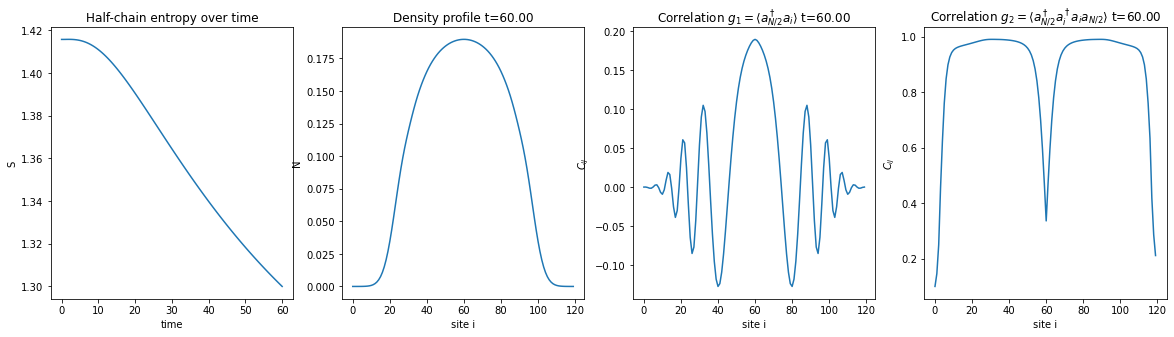

In [5]:
# check time frame and entropy

i_t = -1

# plot a few data panels
fig, ax = plt.subplots(1,4,figsize=(20,5))

S = np.array(data['entropy'][:][:])
ax[0].plot(data['t'][:],S[:,N_site//2])
ax[0].set_xlabel('time')
ax[0].set_ylabel('S')
ax[0].set_title("Half-chain entropy over time")

N = np.array(data['N'][i_t][:])
ax[1].plot(N)
ax[1].set_xlabel('site i')
ax[1].set_ylabel('N')
ax[1].set_title("Density profile t={:.2f}".format(data['t'][i_t]))

g1 = np.array(data['g1'][i_t][N_site//2][:])
ax[2].plot(g1)
ax[2].set_xlabel('site i')
ax[2].set_ylabel(r'$C_{ij}$')
ax[2].set_title(r'Correlation $g_1=\langle a^\dagger_{N/2} a_i \rangle$ t=' + '{:.2f}'.format(data['t'][i_t]))
dens_corr = np.array(data['g2'][i_t][N_site//2][:])

dens_corr[N_site//2] -= N[N_site//2] # for commutator
g2 = dens_corr / N[N_site//2] / (N + 1e-5) # normalize with densities

ax[3].plot(g2)
ax[3].set_xlabel('site i')
ax[3].set_ylabel(r'$C_{ij}$')
ax[3].set_title(r'Correlation $g_2=\langle a^\dagger_{N/2}a^\dagger_{i} a_i a_{N/2}\rangle$ t=' + '{:.2f}'.format(data['t'][i_t]))


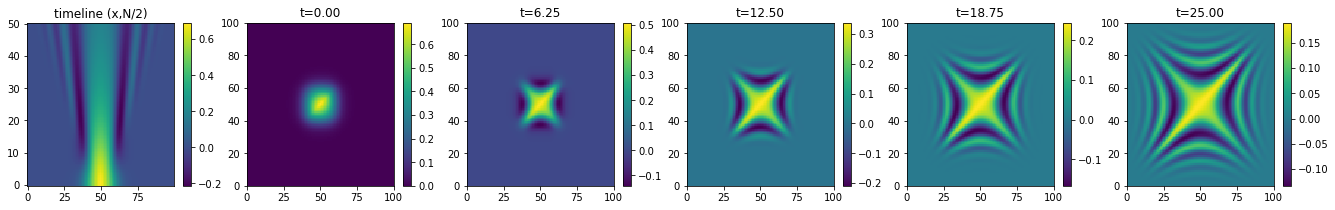

In [14]:
# data to use
u = np.array(data['g1'])
ts = np.array(data['t'])

# plot a few data panels
fig, ax = plt.subplots(1,6,figsize=(23,3))

it_plot = np.array([0, .25, .50, .75, 1.]) * (len(data['t'])-1)
it_plot = it_plot.astype(int)                                                   

pcm = ax[0].pcolormesh(np.arange(N_site),ts,np.real(u[:,:,N_site//2]), shading='auto')
clb = fig.colorbar(pcm, ax=ax[0])
ax[0].set_title("timeline (x,N/2)")


for i, it in enumerate(list(it_plot)):
    pcm = ax[i+1].pcolormesh(np.real(u[it]))
    ax[i+1].set_title("t=" + "{:.2f}".format(ts[it]*J))
    fig.colorbar(pcm, ax=ax[i+1])

In [15]:
# evaluate Theta (symmetric terms only)
#del data
# select fraction of u for analysis
it_start = 0
it_end = -1

x_range = 20

Nt, Nx, Ny = u.shape

# index for selecting elements all variable for analysis
v_t = ts[it_start:it_end]
indx = (slice(it_start,it_end), slice(N_site//2-x_range,N_site//2+x_range+1), slice(N_site//2-x_range,N_site//2+x_range+1))
m, n, o = u[indx].shape

# differentials
dt = ts[1]-ts[0]
dx = 1.

bc = 'periodic'

# start dictionaries for all variables regression
dic_t = dict([])

dic_t['u_t'] = MultiFiniteDiff_t(u, dt, d=1)
dic_t['u_tt'] = MultiFiniteDiff_t(u, dt, d=2)

dic_v = dict([])

# spatial x and y derivatives
u_x = MultiFiniteDiff(u, dx, 1, axis=1, bc=bc)
u_xx = MultiFiniteDiff(u, dx, 2, axis=1, bc=bc)
u_xxx = MultiFiniteDiff(u, dx, 3, axis=1, bc=bc)
u_xxxx = MultiFiniteDiff(u, dx, 4, axis=1, bc=bc)

u_y = MultiFiniteDiff(u, dx, 1, axis=2, bc=bc)
u_yy = MultiFiniteDiff(u, dx, 2, axis=2, bc=bc)
u_yyy = MultiFiniteDiff(u, dx, 3, axis=2, bc=bc)
u_yyyy = MultiFiniteDiff(u, dx, 4, axis=2, bc=bc)

# density
nx = []
ny = []

for i in range(Nt):
  dens = np.diag(u[i,:,:])
  nx.append( np.tile(dens, (Nx,1)).T )
  ny.append( np.tile(dens, (Nx,1)) )
nx = np.array(nx)
ny = np.array(ny)

nx_x = MultiFiniteDiff(nx, dx, 1, axis=1, bc=bc)
ny_y = MultiFiniteDiff(ny, dx, 1, axis=2, bc=bc)

# symmetric and antisymmetric combinations to include
dic_v['u_xx-u_yy'] = u_xx - u_yy
dic_v['u_xxxx-u_yyyy'] = u_xxxx - u_yyyy
dic_v['nx-ny'] = nx-ny
dic_v['nx*u-ny*u'] = (nx-ny)*u
dic_v['u_x^2-u_y^2'] = u_x**2-u_y**2
dic_v['uc_x*u_x-uc_y*u_y'] = np.abs(u_x)**2 - np.abs(u_y)**2
dic_v['nx_x*u_x-ny_y*u_y'] = nx_x*u_x - ny_y*u_y
dic_v['nx_x*u_y-ny_y*u_x'] = nx_x*u_y - ny_y*u_x
dic_v['nx*u_xx-ny*u_yy'] = nx*u_xx - ny*u_yy
dic_v['ny*u_xx-nx*u_yy'] = ny*u_xx - nx*u_yy


# select intervals, resize and add to stacks
X_data = np.hstack([u[indx].reshape((m*n*o),1)])
data_description = ['u']

X_list, derivatives_description = [], []
for key, var in dic_v.items():
    X_list.append( var[indx].reshape((m*n*o,1)) )
    derivatives_description.append( key )
X_ders = np.hstack(X_list)

# build theta
X, descr = build_custom_Theta(X_data, X_ders, derivatives_description, 
                       data_description = data_description)

print(descr)

['', 'u', 'u_xx-u_yy', 'u_xxxx-u_yyyy', 'nx-ny', 'nx*u-ny*u', 'u_x^2-u_y^2', 'uc_x*u_x-uc_y*u_y', 'nx_x*u_x-ny_y*u_y', 'nx_x*u_y-ny_y*u_x', 'nx*u_xx-ny*u_yy', 'ny*u_xx-nx*u_yy']


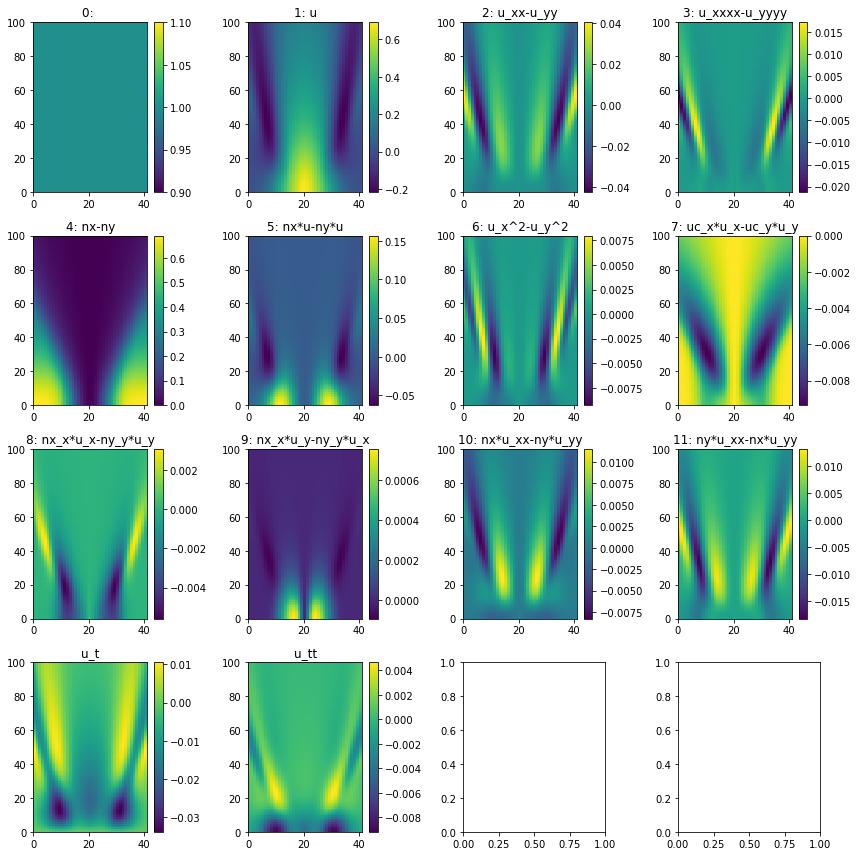

In [16]:
# plot all columns of theta and check for symmetries, anomalies etc and pick the terms you want to add in the fitting
n_panel = len(descr)+2

n_row = 4
n_col = int(np.ceil(n_panel/n_row))


fig, ax = plt.subplots(n_col,n_row,figsize=(n_row*3,n_col * 3))

i = 0
for k in range(n_col):
  for l in range(n_row):
    if i < X.shape[1]:
      pcm = ax[k,l].pcolormesh(np.real(X[:,i]).reshape((m,n,o))[:,n//2,:])
      fig.colorbar(pcm,ax=ax[k,l])
      ax[k,l].set_title(str(i) + ": " + descr[i])
    # u_t
    elif i == X.shape[1]:
      pcm = ax[k,l].pcolormesh(np.real((dic_t['u_t'][indx])[:,n//2,:]))
      fig.colorbar(pcm,ax=ax[k,l])
      ax[k,l].set_title("u_t")
    # u_tt
    elif i == X.shape[1]+1:
      pcm = ax[k,l].pcolormesh(np.real((dic_t['u_tt'][indx])[:,n//2,:]))
      fig.colorbar(pcm,ax=ax[k,l])
      ax[k,l].set_title("u_tt")

    i += 1

fig.tight_layout()

In [17]:
# select terms from pictures to include in search (discard all options that are almost zero or do not satisfy symmetries)

# big selection
#i_theta_select = (10,11,12,13,14,19,26)

# check quick

#theta_search = ['u','u_x^2-u_y^2', 'uc_x*u_x-uc_y*u_y', 'nx_x*u_x-ny_y*u_y', 'nx_x*u_y-ny_y*u_x','u_xxxx-u_yyyy']
#theta_search = ['u_xx+u_yy']
theta_fix = ['u_xx-u_yy','nx*u-ny*u']
theta_search = [th for th in dic_v.keys() if th not in theta_fix ]
#theta_search = []
print(theta_search)

#theta_select = descr[2:]
theta_select = theta_fix + theta_search
i_theta_select = []
for name in theta_select:
  i_theta_select.append( descr.index(name) )

print(i_theta_select)
print("Searches: {}".format(2**len(theta_search)) )

['u_xxxx-u_yyyy', 'nx-ny', 'u_x^2-u_y^2', 'uc_x*u_x-uc_y*u_y', 'nx_x*u_x-ny_y*u_y', 'nx_x*u_y-ny_y*u_x', 'nx*u_xx-ny*u_yy', 'ny*u_xx-nx*u_yy']
[2, 5, 3, 4, 6, 7, 8, 9, 10, 11]
Searches: 256


In [18]:
# u_t Brute Force

import functions_regression
reload( functions_regression )
from functions_regression import *
l0 = 0.1 # just default value, no search
verbose = 0 # output

X_select = X.take(i_theta_select, axis=1)
descr_select = list(np.take(descr, i_theta_select))

ut = dic_t['u_t'][indx].reshape((m*n*o,1))

start = time.time()
train_data_t = BruteForceL0(X_select, ut, descr_select, l0_penalty=l0, lam_l2=0., verbose=verbose, lhs_descr="u_t", fixed_columns=theta_fix)
#train_data_tt = BruteForceL0(X_select, utt, descr_select, l0_penalty=.01, lam_l2=0., verbose=1, lhs_descr="u_tt")

print("Full error: {:.4f}".format(train_data_t[1]['err_best']))
print("MSE: {:.4f}".format(train_data_t[1]['err_best'] - l0*np.sum(np.abs(train_data_t[0]) > 0. )) )
print("Finished in {:.2f}s".format(time.time()-start))
#print(coefs)

utils/functions_regression.py:312: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(X, TrainY)[0]
utils/functions_regression.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w[list(indexes)] = np.linalg.lstsq(TrainR[:, list(indexes)], TrainY)[0]


u_t = (-0.000032 -0.496063i)u_xx-u_yy
    + (-0.000003 +0.320533i)nx*u-ny*u
   
Time elapsed 9.824670553207397
Full error: 0.3745
MSE: 0.1745
Finished in 9.83s


In [46]:
# evaluate obtained PDE

import functions_PDE_solver
reload( functions_PDE_solver )
from functions_PDE_solver import *

nskip = 10

# dirichlet boundary, make sure end points are 0
# dirichlet_bc = []
# for i in range(N_site):
#     dirichlet_bc.append((0,i,0.))
#     dirichlet_bc.append((-1,i,0.))
#     dirichlet_bc.append((i,0,0.))
#     dirichlet_bc.append((i,-1,0.))

# select part to evolve (upper-right quarter correlations)
u_int = u[:,:,:]

coefs = train_data_t[0]
coefs_bare = np.zeros(len(coefs), dtype=complex)
coefs_bare[0:2] = [-1j*J,1j*U]

# initial condition
t_rec = np.array(ts)
u0 = u_int[0,:,:]
#v0 = (u_int[it_start] - u_int[it_start-1])/(t[1]-t[0])
#coefs = np.array([[-1j*J_eff],[0.]])
u_test = scalar_pde_solver(descr_select, coefs, u0, t_rec, dx, Q=None, v0=None, dirichlet_bc=None, bc="open", nskip=nskip)
u_bare = scalar_pde_solver(descr_select, coefs_bare, u0, t_rec, dx, Q=None, v0=None, dirichlet_bc=None, bc="open", nskip=nskip) 

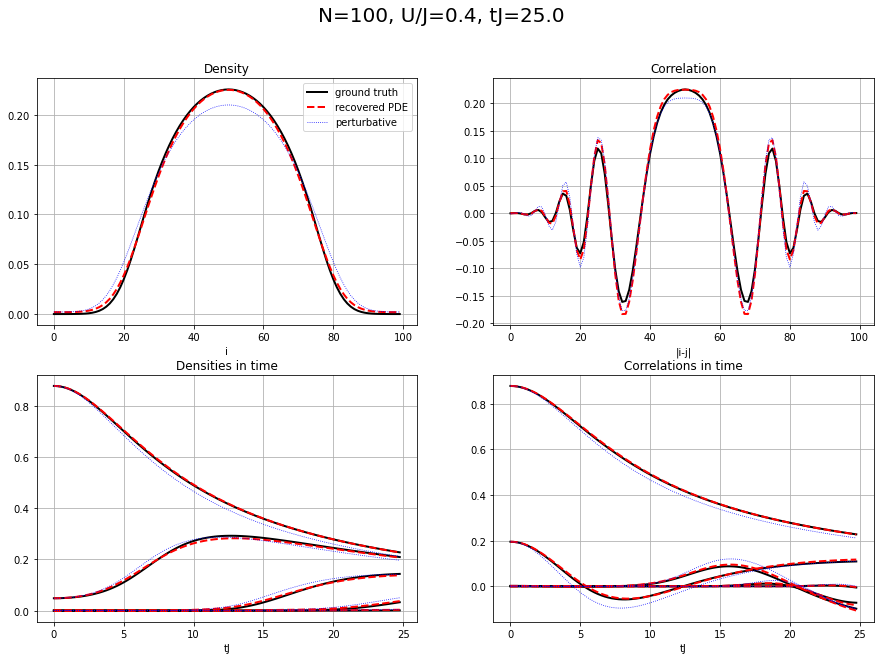

In [47]:
# plot comparison

# data to plot
ind_t = N_site // 1
ind_x = range(N_site//2,N_site,10)

# ground truth
u_true = u_int[:,:,:]

# densities
n_test = np.real(np.array([u_test[:,i,i] for i in range(N_site)]).T)
n_true = np.real(np.array([u_true[:,i,i] for i in range(N_site)]).T)
n_bare = np.real(np.array([u_bare[:,i,i] for i in range(N_site)]).T)
# n_test = np.zeros((u_test.shape[0],u_test.shape[1]))
# n_true = np.zeros((u_true.shape[0],u_true.shape[1]))
# for i in range(N_site):
#   n_test[:,i] = u_test[:,i,i]
#   n_true[:,i] = u_true[:,i,i]

# the figure
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].plot(n_true[ind_t,:].T,"k", linewidth=2., label="ground truth")
_=ax[0,0].plot(n_test[ind_t,:].T,"r--", linewidth=2., label="recovered PDE")
_=ax[0,0].plot(n_bare[ind_t,:].T,"b:", linewidth=.8, label="perturbative")
ax[0,0].set_title('Density')
ax[0,0].legend()
ax[0,0].set_xlabel('i')

ax[0,1].plot(np.real(u_true)[ind_t,N_site//2, :].T,"k", linewidth=2., label="ground truth")
_=ax[0,1].plot(np.real(u_test)[ind_t,N_site//2, :].T,"r--", linewidth=2., label="recovered PDE")
_=ax[0,1].plot(np.real(u_bare)[ind_t,N_site//2, :].T,"b:", linewidth=.8, label="peturbative")
ax[0,1].set_title('Correlation')
ax[0,1].set_xlabel('|i-j|')

ax[1,0].plot(t_rec[:ind_t]*J,n_true[:ind_t,ind_x],"k", linewidth=2.)
_=ax[1,0].plot(t_rec[:ind_t]*J,n_test[:ind_t,ind_x],"r--", linewidth=2.)
_=ax[1,0].plot(t_rec[:ind_t]*J,n_bare[:ind_t,ind_x],"b:", linewidth=.8)
ax[1,0].set_title('Densities in time')
ax[1,0].set_xlabel('tJ')

ax[1,1].plot(t_rec[:ind_t]*J,np.real(u_true)[:ind_t,N_site//2,ind_x],"k", linewidth=2.)
_=ax[1,1].plot(t_rec[:ind_t]*J,np.real(u_test)[:ind_t,N_site//2,ind_x],"r--", linewidth=2.)
_=ax[1,1].plot(t_rec[:ind_t]*J,np.real(u_bare)[:ind_t,N_site//2,ind_x],"b:", linewidth=.8)
ax[1,1].set_title('Correlations in time')
ax[1,1].set_xlabel('tJ')


fig.suptitle('N={}, U/J={:.1f}, tJ={:.1f}'.format(N_site, U/J, t_rec[ind_t]*J), fontsize=20)

for va in ax:
  for a in va:
    a.grid(True)

In [55]:
n_bare.sum(axis=1)

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [19]:
150**3

3375000